<a href="https://colab.research.google.com/github/GuilhermeN391/Heart_Disease_App/blob/main/Heart_Disease_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação das Bibliotecas necessárias**

Bibliotecas utilizadas ao longo do desenvolvimento do modelo e armazenamento dos seus resultados.

In [ ]:
!pip install wandb
!pip install ydata-profiling
!pip install pytest pytest-sugar

In [ ]:
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import tempfile
import os
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, roc_auc_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
import glob
import os
import wandb
import joblib
import logging

# **Análise Exploratória dos Dados (EDA)**
Compreender a distribuição dos dados, se há classes
desbalanceadas, estatística das variáveis.



**O projeto escolhido foi o Heart Disaese App do Github user** *maxim-eyengue*

[Link do repositório](https://github.com/maxim-eyengue/Heart-Disease-App)



## **Carregamento dos dados**

Armazenamento no wandb no projeto "Heart_Disease"

Features Description:
*   **age**: age of the patient [years: Numeric]
*   **sex**: gender of the patient [1: Male, 0: Female]
*   **cp**: chest pain type [0: Typical Angina, 1: Atypical Angina, 2: Non-Anginal Pain, 3: Asymptomatic]
*   **trestbps**: resting blood pressure [mm Hg: Numeric]
*   **chol**: serum cholesterol level [mg/dl: Numeric]
*   **fbs**: fasting blood sugar [1: if fasting blood sugar > 120 mg/dl, 0: otherwise]
*   **restecg**: resting electrocardiographic results [0: Normal, 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), 2: showing probable or definite left ventricular hypertrophy by Estes' criteria]
*   **thalach**: maximum heart rate achieved [Numeric value between 60 and 202]
*   **exang**: exercise-induced angina [1: Yes, 0: No]
*   **oldpeak**: ST depression induced by exercise relative to rest [Numeric value measured in depression]
*   **slope**: slope of the peak exercise ST segment [0: Upsloping, 1: Flat, 2: Downsloping]
*   **ca**: number (0-3) of major vessels (arteries, veins, and capillaries) colored by fluoroscopy [0, 1, 2, 3]
*   **thal**: Thalassemia types [1: Normal, 2: Fixed defect, 3: Reversible defect]
*   **target**: outcome variable for heart attack risk [1: disease or more chance of heart attack, 0: normal or less chance of heart attack]




In [ ]:
# Colunas utilizadas
columns = ['age', 'sex', 'cp', 'trestbps', 'chol',
           'fbs', 'restecg', 'thalachh', 'exang',
           'oldpeak','slope','ca', 'thal', 'target']
# Importação do Dataset
income = pd.read_csv("https://raw.githubusercontent.com/maxim-eyengue/Heart-Disease-App/03add8ca4ceb193042893c3a1bffe9c65b5f7cbd/data/raw_merged_heart_dataset.csv",
                   header=None,
                   names=columns,
                   skiprows=1 # Ignora a primeira linha, que não possui dados
                   )
income.head()

Informações referentes as *features* do Dataset importado

In [ ]:
income.info()

### **Conversões de variáveis**

Para tratar e codificar os dados recebidos do dataset, envolvendo correção de dados inconsistentes e conversão de Dtype nos casos necessários.

In [ ]:
# Map sex values
income["sex"] = income["sex"].replace({1: "male", 0: "female"})
# Sex variable values
income.sex.value_counts()

In [ ]:
# Target mapping
income["target"] = income["target"].replace({1: "disease", 0: "normal"})
# Target distribution
income.target.value_counts()

In [ ]:
# Chest Pain values mapping
income["cp"] = income["cp"].replace({4: np.nan, 3: "asymptomatic", 2: "non_anginal_pain", 1: "atypical_angina", 0: "typical_angina"})
# Chest Pain distribution
income.cp.value_counts()

In [ ]:
# Convert resting blood pressure
income.trestbps = pd.to_numeric(income.trestbps, errors = 'coerce')
# Convert cholesterol
income.chol = pd.to_numeric(income.chol, errors = 'coerce')
# Convert maximum heart rate
income.thalachh = pd.to_numeric(income.thalachh, errors = 'coerce')

Listagem de colunas categóricas

In [ ]:
# list of categorical feature variables
categorical = income.drop(columns = "target").select_dtypes("object").columns.to_list()
numerical = income.select_dtypes("number").columns.to_list()

# For each categorical variable
for cat in categorical:
    # Print the variable and its values
    print(f"{cat} --> {income[cat].unique()}")

In [ ]:
# Fasting blood sugar values mapping
income["fbs"] = income["fbs"].replace({"1": "high_fbs", "0": "low_fbs",
                               "?": np.nan})

# Resting electrocardiographic results mapping
income["restecg"] = income["restecg"].replace({"2": "left_ventricular_hypertrophy",
                                       "1": "st_t_wave_abnormality",
                                       "0": "normal", "?": np.nan})

# Exercise-induced angina values mapping
income["exang"] = income["exang"].replace({"1": "yes", "0": "no",
                                   "?": np.nan})

# Slope values mapping
income["slope"] = income["slope"].replace({"3": np.nan, "2": "downsloping",
                                   "1": "flat", "0": "upsloping", "?": np.nan})

# Major vessels mapping
income["ca"] = income["ca"].replace({"4": np.nan, "3": "three_vessels", "2": "two_vessels",
                             "1": "one_vessel", "0": "no_vessel", "?": np.nan})

# Thalassemia types values mapping
income["thal"] = income["thal"].replace({"7": np.nan, "6": np.nan, "3": "reversible_defect",
                                 "2": "fixed_defect", "1": "normal", "0": np.nan, "?": np.nan})

In [ ]:
# For each categorical variable
for cat in categorical:
    # Print the variable and its values
    print(f"{cat} --> {income[cat].unique()}")

Informações do Dataset após a realização das conversões.

In [ ]:
income.info()

### **Envio para o wandb**

O repositório criado no wanb irá armazenar os dados de treinamento e teste, além de métricas, parãmetros e gráficos importantes para o trabalho.

In [ ]:
income.to_csv("raw_data.csv",index=False)

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [ ]:
# Send the raw_data.csv to the Wandb storing it as an artifact
!wandb artifact put \
      --name Heart_Disease/raw_data.csv \
      --type raw_data \
      --description "The raw data from Heart Disease App" raw_data.csv

In [ ]:
# save_code tracking all changes of the notebook and sync with Wandb
run = wandb.init(project="Heart_Disease", save_code=True)

# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact("Heart_Disease/raw_data.csv:latest")

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

Indicação de dados nulos em cada coluna do Dataset salvo no wandb

In [ ]:
df.isnull().sum()

,0
age,0
sex,0
cp,252
trestbps,1
chol,23
fbs,8
restecg,1
thalachh,1
exang,1
oldpeak,0


## **Realizada a EDA a partir da biblioteca Pandas Profiling**

A análise exploratória de dados do projeto foi realizada através da biblioteca Pandas Profiling, que emite o relatório de cada feature do Dataset, além do contexto geral dos dados trabalhados.

In [ ]:
ProfileReport(df, title="Pandas Profiling Report", explorative=True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 14/14 [00:00<00:00, 30.27it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
run.finish()

# **Preparação e Engenharia de Atributos**
Realizar a limpeza (removendo ou imputando
registros incompletos) e transformar atributos para
um formato adequado ao modelo.

## **Correção de valores perdidos**

O dataset trabalhado possui categorias com alto índice de dados perdidos, sendo assim será feita uma correção no dataset para contornar esse problema intriseco.

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

In [ ]:
# save_code tracking all changes of the notebook and sync with Wandb
run = wandb.init(project="Heart_Disease", save_code=True)

# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact("Heart_Disease/raw_data.csv:latest")

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

In [ ]:
df.info()

In [ ]:
# Percentages of missing values
round(100 * df.isnull().sum() / len(df), 2)

As classes a seguir possuem uma baixa perda de valores, sendo assim a correção será feita aplicando a mediana para valores numéricos e a moda para valores categoricos.

In [ ]:
# Replacing numerical missing values by median
df.fillna(value = df[["trestbps", "chol", "thalachh"]].median(), inplace = True)

# Replacing categorical missing values by mode
df["fbs"] = df["fbs"].fillna(value = df["fbs"].mode()[0])
df["restecg"] = df["restecg"].fillna(value = df["restecg"].mode()[0])
df["exang"] = df["exang"].fillna(value = df["exang"].mode()[0])

Algumas observações podem ter muitos valores ausentes em colunas diferentes. Não deve substituí-los diretamente, pois isso pode inserir vieses nos dados trabalhados, será feita a verificação das observações que possuem valores ausentes em pelo menos duas colunas e em seguida será feita a sua exclusão.

In [ ]:
# List of columns with missing values
missing_features = ["cp", "slope", "ca", "thal"]

# For each variale
for first_miss in missing_features:
    # Check another variable
    for second_miss in missing_features:
        # Make sure those variables are different
        if first_miss != second_miss:
            # Get index of observations to drop
            index_to_drop = (df[(df[first_miss].isnull())
                             & (df[second_miss].isnull())].index)
            # Drop missing data
            df.drop(index_to_drop, axis = 'index', inplace = True)

# Percentages of missing values
round(100 * df.isnull().sum() / len(df), 2)

In [ ]:
# Replacing categorical missing values by mode
df["cp"] = df["cp"].fillna(value = df["cp"].mode()[0])
df["slope"] = df["slope"].fillna(value = df["slope"].mode()[0])
df["ca"] = df["ca"].fillna(value = df["ca"].mode()[0])
df["thal"] = df["thal"].fillna(value = df["thal"].mode()[0])

In [ ]:
# Count of missing values
df.isnull().sum()

Codificação da feature de classificação do problema ("target").

In [ ]:
# Target encoding
df["target"] = (df["target"] == "disease").astype(int)

In [ ]:
df.info()

## **Realização do Pre-Processing**

In [ ]:
!wandb login --relogin

In [ ]:
input_artifact="Heart_Disease/raw_data.csv:latest"
artifact_name="preprocessed_data.csv"
artifact_type="clean_data"
artifact_description="Data after preprocessing"

In [ ]:
# create a new job_type
run = wandb.init(project="Heart_Disease", job_type="process_data")

In [ ]:
# donwload the latest version of artifact raw_data.csv
artifact = run.use_artifact(input_artifact)

# create a dataframe from the artifact
df = pd.read_csv(artifact.file())

In [ ]:
df.info()

Quantitativo de repetições de dados catalogados.

In [ ]:
df.duplicated().sum()

In [ ]:
# Delete duplicated rows
df.drop_duplicates(inplace=True)

df.info()

### Envio do Dataset limpo para o wandb

In [ ]:
# Generate a "clean data file"
df.to_csv(artifact_name,index=False)

In [ ]:
# Create a new artifact and configure with the necessary arguments
artifact = wandb.Artifact(name=artifact_name,
                          type=artifact_type,
                          description=artifact_description)
artifact.add_file(artifact_name)

# Upload the artifact to Wandb
run.log_artifact(artifact)

In [ ]:
# close the run
# waiting a while after run the previous cell before execute this
run.finish()

## **Realização do Data Check com *pytest***

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

In [ ]:
%%file test_data.py
import pytest

# This is global so all tests are collected under the same run
run = wandb.init(project="Heart_Disease", job_type="data_checks")

@pytest.fixture(scope="session")
def data():

    local_path = run.use_artifact("Heart_Disease/preprocessed_data.csv:latest").file()
    df = pd.read_csv(local_path)

    return df

def test_data_length(data):
    """
    We test that we have enough data to continue
    """
    assert len(data) > 500


def test_number_of_columns(data):
    """
    We test that we have enough data to continue
    """
    assert data.shape[1] == 14

def test_column_presence_and_type(data):

    required_columns = {
        "age": pd.api.types.is_int64_dtype,
        "sex": pd.api.types.is_object_dtype,
        "cp": pd.api.types.is_object_dtype,
        "trestbps": pd.api.types.is_float_dtype,
        "chol": pd.api.types.is_float_dtype,
        "fbs": pd.api.types.is_object_dtype,
        "restecg": pd.api.types.is_object_dtype,
        "thalachh": pd.api.types.is_float_dtype,
        "exang": pd.api.types.is_object_dtype,
        "oldpeak": pd.api.types.is_float_dtype,
        "slope": pd.api.types.is_object_dtype,
        "ca": pd.api.types.is_object_dtype,
        "thal": pd.api.types.is_object_dtype,
        "target": pd.api.types.is_int64_dtype
    }

    # Check column presence
    assert set(data.columns.values).issuperset(set(required_columns.keys()))

    for col_name, format_verification_funct in required_columns.items():

        assert format_verification_funct(data[col_name]), f"Column {col_name} failed test {format_verification_funct}"


def test_class_names(data):

    # Check that only the known classes are present
    known_classes = [
        0,
        1
    ]

    assert data["target"].isin(known_classes).all()


def test_column_ranges(data):

    ranges = {
        "age": (28, 77),
        "trestbps": (92, 200),
        "chol": (85, 603),
        "thalachh": (71, 202),
        "oldpeak": (0, 6.2)
    }

    for col_name, (minimum, maximum) in ranges.items():

        assert data[col_name].dropna().between(minimum, maximum).all(), (
            f"Column {col_name} failed the test. Should be between {minimum} and {maximum}, "
            f"instead min={data[col_name].min()} and max={data[col_name].max()}"
        )

In [ ]:
!pytest . -vv

In [ ]:
# close the run
# waiting a while after run the previous cell before execute this
run.finish()

## **Data Segragation**

Separação de dados para treinamento e teste e envio para o wandb.

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

In [ ]:
# global variables

# ratio used to split train and test data
test_size = 0.20

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "target"

# name of the input artifact
artifact_input_name = "Heart_Disease/preprocessed_data.csv:latest"

# type of the artifact
artifact_type = "segregated_data"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate wandb project
run = wandb.init(project="Heart_Disease", job_type="split_data")

logger.info("Downloading and reading artifact")
artifact = run.use_artifact(artifact_input_name)
artifact_path = artifact.file()
df = pd.read_csv(artifact_path)

# Split firstly in train/test, then we further divide the dataset to train and validation
logger.info("Splitting data into train and test")
splits = {}

splits["train"], splits["test"] = train_test_split(df,
                                                   test_size=test_size,
                                                   random_state=seed,
                                                   stratify=df[stratify])

# Save the artifacts. We use a temporary directory so we do not leave any trace behind
with tempfile.TemporaryDirectory() as tmp_dir:

    for split, df in splits.items():

        # Make the artifact name from the name of the split plus the provided root
        artifact_name = f"{split}.csv"

        # Get the path on disk within the temp directory
        temp_path = os.path.join(tmp_dir, artifact_name)

        logger.info(f"Uploading the {split} dataset to {artifact_name}")

        # Save then upload to W&B
        df.to_csv(temp_path,index=False)
        artifact = wandb.Artifact(name=artifact_name,
                                  type=artifact_type,
                                  description=f"{split} split of dataset {artifact_input_name}",
        )
        artifact.add_file(temp_path)

        logger.info("Logging artifact")
        run.log_artifact(artifact)

        # This waits for the artifact to be uploaded to W&B. If you
        # do not add this, the temp directory might be removed before
        # W&B had a chance to upload the datasets, and the upload
        # might fail
        artifact.wait()

In [ ]:
# close the run
# waiting a while after run the previous cell before execute this
run.finish()

# **Implementação do Modelo em Pytorch**
Utilizando a classe base fornecida pelo professor em
aula, implementar a regressão logística.

In [ ]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [ ]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Aqui definimos os atributos inicialização da nossa classe

        # Começamos armazenando os argumentos como atributos
        # para usá-los mais tarde
        self.model = model #modelo
        self.loss_fn = loss_fn #função de perda
        self.optimizer = optimizer #Otimizador
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Vamos enviar o modelo para o device ('cuda') especificado
        self.model.to(self.device)

        # Esses atributos são definidos aqui, mas como não são
        # informados no momento da criação, mantemos o estado 'None'
        self.train_loader = None
        self.val_loader = None

        # Esses atributos serão computados internamente
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Criação a função train_step para o nosso modelo,
        # função de perda e otimizador
        # Observação: NÃO HÁ ARGUMENTOS aqui! Ele usa a classe
        # "attributes" diretamente
        self.train_step_fn = self._make_train_step_fn()
        # Cria a função val_step para nosso modelo e perda
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # Este método permite que o usuário especifique um device diferente
        # Ele define o atributo correspondente (a ser usado posteriormente
        # nos mini-batches) e envia o modelo para o device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # Este método permite que o usuário defina qual train_loader (e val_loader, opcionalmente) usar.
        # Ambos os loaders são então atribuídos aos atributos da classe.
        # Para que possam ser referenciados posteriormente.
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # Este método não precisa de argumentos... ele pode se referir aos
        # atributos: self.model, self.loss_fn e self.optimizer

        # Cria uma função que executa uma etapa no loop de treinamento
        def perform_train_step_fn(x, y):
            # Define o modelo para o modo de treinamento
            self.model.train()

            # Passo 1 - Computa a saída prevista do nosso modelo - forward pass
            yhat = self.model(x)
            # Passo 2 - Computa as perdas
            loss = self.loss_fn(yhat, y)
            # Passo 3 - Calcula os gradientes para os parâmetros "a" e "b"
            loss.backward()
            # Passo 4 - Atualiza os parâmetros usando os gradientes atualidados
            # e a taxa de aprendizagem
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Retorna as perdas
            return loss.item()

        # Retorna a função que será chamada dentro do loop de treinamento
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Cria uma função que executa uma etapa no loop de validação
        def perform_val_step_fn(x, y):
            # Define o modelo para o modo EVAL
            self.model.eval()

            # Passo 1
            yhat = self.model(x)
            # Passo 2
            loss = self.loss_fn(yhat, y)
            # Não há necessidade de calcular as etapas 3 e 4, pois não
            # atualizamos os parâmetros durante a avaliação
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # O mini-batch pode ser usado com ambos os loaders
        # O argumento 'validation' define qual carregador e
        # a função de step correspondente serão usados
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Uma vez que o data loader e a função de step, este é o mesmo
        # loop de mini-batch que tínhamos antes
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # Para garantir a reprodutibilidade do processo de treinamento
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Mantém o registro do número de épocas
            # atualizando o atributo correspondente
            self.total_epochs += 1

            # loop interno
            # Executa treinamento usando mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDAÇÃO
            # SEM GRADIENTES NA VALIDAÇÃO!
            with torch.no_grad():
                # Executa avaliação usando mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Cria um dicionário com todos os elementos para retomar o treinamento
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Carrega o dicionário
        checkpoint = torch.load(filename,weights_only=False)

        # Restaurar estado para modelo e otimizador
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # sempre use TRAIN para retomar o treinamento

    def predict(self, x):
        # O conjunto está no modo de avaliação para previsões
        self.model.eval()
        # Recebe uma entrada Numpy e a transforma em um tensor float
        x_tensor = torch.as_tensor(x).float()
        # Envia entrada para o device e usa o modelo para previsão
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Coloca de volta no modo de treinamento
        self.model.train()
        # Desconecta-o e leva-o para a CPU e de volta para o Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

# **Treinamento do Modelo**
Dividir o dataset em conjunto de treino e teste,
configurar um otimizador, iterar por múltiplas
épocas, calcular a loss e gradientes.

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

## Holdout Configuration

Estratificação da feature de classificação do problema.

In [ ]:
# global variables

# seed used to reproduce purposes
seed = 41

# reference (column) to stratify the data
stratify = "target"

# name of the input artifact
artifact_input_name_train = "Heart_Disease/train.csv:latest"
artifact_input_name_test = "Heart_Disease/test.csv:latest"

# type of the artifact
artifact_type_train = "Train"
artifact_type_test = "Test"

In [ ]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()

# initiate the wandb project
run = wandb.init(project="Heart_Disease",job_type="train")

logger.warning("Downloading and reading train artifact")
local_path_train = run.use_artifact(artifact_input_name_train).file()
df_train = pd.read_csv(local_path_train)

logger.warning("Downloading and reading test artifact")
local_path_test = run.use_artifact(artifact_input_name_test).file()
df_test = pd.read_csv(local_path_test)

# Spliting train.csv into train and validation dataset
logger.warning("Spliting data into train/val")
# split-out train/validation and test dataset
X_train = df_train.drop(stratify, axis=1)
y_train = df_train[stratify]
X_test = df_test.drop(stratify, axis=1)
y_test = df_test[stratify]

## Codificando as colunas usando pipeline

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    # Class Constructor
    def __init__(self, feature_names):
        self.feature_names = feature_names

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    # Method that describes what this custom transformer need to do
    def transform(self, X, y=None):
        return X[self.feature_names]

### Handling Categorical Features

In [ ]:
# Handling categorical features
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes one boolean as its argument
    def __init__(self, new_features=True, colnames=None):
        self.new_features = new_features
        self.colnames = colnames

    # Return self nothing else to do here
    def fit(self, X, y=None):
        return self

    def get_feature_names_out(self):
        return self.colnames.tolist()

    # Transformer method we wrote for this transformer
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # Remove white space in categorical features
        df = df.apply(lambda row: row.str.strip())

        # update column names
        self.colnames = df.columns

        return df


### Handling Numerical Features

In [ ]:
# transform numerical features
class NumericalTransformer(BaseEstimator, TransformerMixin):
    # Class constructor method that takes a model parameter as its argument
    # model 0: minmax
    # model 1: standard
    # model 2: without scaler
    def __init__(self, model=0, colnames=None):
        self.model = model
        self.colnames = colnames
        self.scaler = None

    # Fit is used only to learn statistical about Scalers
    def fit(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)
        # minmax
        if self.model == 0:
            self.scaler = MinMaxScaler()
            self.scaler.fit(df)
        # standard scaler
        elif self.model == 1:
            self.scaler = StandardScaler()
            self.scaler.fit(df)
        return self

    # return columns names after transformation
    def get_feature_names_out(self):
        return self.colnames

    # Transformer method we wrote for this transformer
    # Use fitted scalers
    def transform(self, X, y=None):
        df = pd.DataFrame(X, columns=self.colnames)

        # update columns name
        self.colnames = df.columns.tolist()

        # minmax
        if self.model == 0:
            # transform data
            df = self.scaler.transform(df)
        elif self.model == 1:
            # transform data
            df = self.scaler.transform(df)
        else:
            df = df.values

        return df

### Data Preparation Pipeline

Pipeline feito para aplicar as colunas categóricas a OneHotEnconder para converter em colunas numéricas. Além da normalização das colunas numéricas.

In [ ]:
# model = 0 (min-max), 1 (z-score), 2 (without normalization)
numerical_model = 0

# Categrical features to pass down the categorical pipeline
categorical_features = X_train.select_dtypes("object").columns.to_list()

# Numerical features to pass down the numerical pipeline
numerical_features = X_train.select_dtypes('number').columns.to_list()

# Defining the steps for the categorical pipeline
categorical_pipeline = Pipeline(steps=[('cat_selector', FeatureSelector(categorical_features)),
                                       ('imputer_cat', SimpleImputer(strategy="most_frequent")),
                                       ('cat_transformer', CategoricalTransformer(colnames=categorical_features)),
                                       # ('cat_encoder','passthrough'
                                       ('cat_encoder', OneHotEncoder(sparse_output=False, drop="first"))
                                       ]
                                )

# Defining the steps in the numerical pipeline
numerical_pipeline = Pipeline(steps=[('num_selector', FeatureSelector(numerical_features)),
                                     ('imputer_num', SimpleImputer(strategy="median")),
                                     ('num_transformer', NumericalTransformer(numerical_model,
                                                                              colnames=numerical_features))])

# Combine numerical and categorical pieplines into one full big pipeline horizontally
full_pipeline_preprocessing = FeatureUnion(transformer_list=[('cat_pipeline', categorical_pipeline),
                                                             ('num_pipeline', numerical_pipeline)]
                                           )

In [ ]:
# train
new_data_train = full_pipeline_preprocessing.fit_transform(X_train)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
X_train_normalized = pd.DataFrame(new_data_train,columns = cat_names + num_names)
X_train_normalized.head()

In [ ]:
# test
new_data_test = full_pipeline_preprocessing.fit_transform(X_test)
# cat_names is a numpy array
cat_names = full_pipeline_preprocessing.get_params()["cat_pipeline"][3].get_feature_names_out().tolist()
# num_names is a list
num_names = full_pipeline_preprocessing.get_params()["num_pipeline"][2].get_feature_names_out()
X_test_normalized = pd.DataFrame(new_data_test,columns = cat_names + num_names)
X_test_normalized.head()

## Treinamento utilizando o modelo desenvolvido no PyTorch

In [ ]:
# Constantes utilizadas para o treio

DATASET_FOLDER_PATH = "dataset" #caminho para o dataset
BATCH_SIZE = 64 #número de batches para o treino
LEARNING_RATE = 0.01 #taxa de aprendizado
NUM_EPOCHS = 40 #Número de época para treinamento

# Definição da função sigmoide para usar na avaliação
def sigmoid(z):
 return 1 / (1 + np.exp(-z))


# Configuração do dispositivo no pytorch para rodar na GPU se disponível
# Caso não tenha GPU, o código rodará na CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Dispositivo utilizado: {device}")


Preparação dos dados, dada a necessidade de converter as colunas do dataset em valores numéricos

In [ ]:
# Converter a coluna time_bin (categoria com intervalos) para valores numéricos
if 'time_bin' in X_train_normalized.columns:
    # Extrair o ponto médio de cada intervalo
    X_train_normalized['time_bin'] = X_train_normalized['time_bin'].apply(lambda x: x.mid if isinstance(x, pd.Interval) else x)
    X_test_normalized['time_bin'] = X_test_normalized['time_bin'].apply(lambda x: x.mid if isinstance(x, pd.Interval) else x)

    print("Coluna time_bin convertida para valores numéricos (ponto médio do intervalo)")

# Agora é possível aplicar o StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normalized)
X_test_scaled = scaler.transform(X_test_normalized)

print("Normalização concluída com sucesso!")

Conversão das entradas para tensores pytorch e criação dos loaders para treinamento.

In [ ]:
torch.manual_seed(13)

# Constroi tensores a partir de arrays Numpy
x_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train.values.reshape(-1, 1))

x_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test.values.reshape(-1, 1))


# Cria um conjunto de dados contendo TODOS os data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

# Constroi um Loader de cada conjunto
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True
)
test_loader = DataLoader(dataset=test_dataset, batch_size=16)

In [ ]:
# Definir modelo, perda e otimizador
input_dim = X_train_normalized.shape[1] # Número de features

# Definir o modelo de regressão logística (uma única camada linear)
torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(input_dim, 1))

# Calcular peso para a classe positiva (Doente) para lidar com desbalanceamento
n_samples = len(y_train)
n_disease = np.sum(y_train)
n_normal = n_samples - n_disease
print(f"\nCalculando peso para classe positiva (doente):")
print(f"Total de amostras: {n_samples}")
print(f"Amostras normais: {n_normal}")
print(f"Amostras doentes: {n_disease}")
print(f"Proporção: {n_normal / n_disease:.2f}:1")

# Definir função de perda
loss_fn = nn.BCEWithLogitsLoss()
# Definir otimizador SGD (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# Inicializar a arquitetura de treinamento
arch = Architecture(model, loss_fn, optimizer)
arch.set_loaders(train_loader, test_loader)
# Treinar o modelo
print(f"Iniciando treinamento por {NUM_EPOCHS} épocas...")
arch.train(NUM_EPOCHS)
print("Treinamento concluído!")

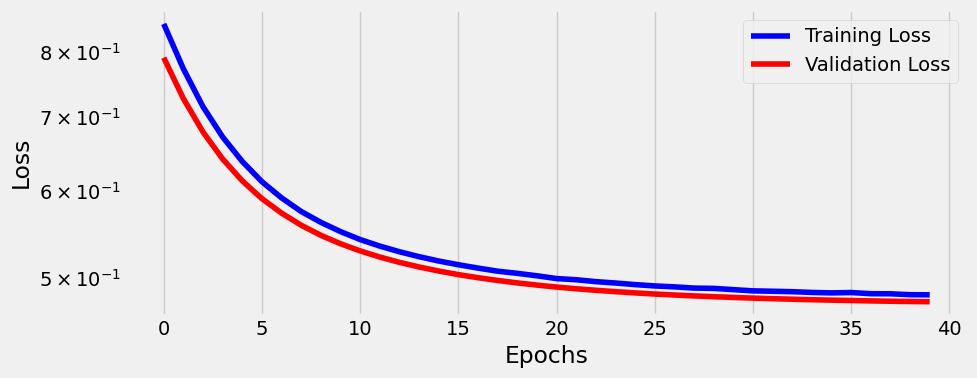

In [ ]:
# Plotar evolução da perda
loss_fig = arch.plot_losses()
plt.show()

In [ ]:
run.finish()

# **Avaliação do Modelo**
Após treinado, avaliar o desempenho do classificador
no conjunto de teste.

## Implementações das métricas de avaliação

$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [ ]:
# Métricas de avaliação do modelo
def precision_recall(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall

def tpr_fpr(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    return tpr, fpr

# Cálculo de F1-score e especificidade
def f1_score_manual(precision, recall):
    return 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

def specificity(cm):
    tn, fp = cm[0]
    fn, tp = cm[1]
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Adicionando função para visualizar as probabilidades em uma linha
def figure10(y, probabilities, threshold=0.5, shift=0.04, annot=True):
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))

    # Configurações do plot
    ax.grid(False)
    ax.set_ylim([-.1, .1])
    ax.axes.get_yaxis().set_visible(False)
    ax.plot([0, 1], [0, 0], linewidth=2, c='k', zorder=1)
    ax.plot([0, 0], [-.1, .1], c='k', zorder=1)
    ax.plot([1, 1], [-.1, .1], c='k', zorder=1)

    # Identificar os diferentes tipos de classificação
    tn = (y == 0) & (probabilities < threshold)
    fn = (y == 0) & (probabilities >= threshold)
    tp = (y == 1) & (probabilities >= threshold)
    fp = (y == 1) & (probabilities < threshold)

    # Desenhar o threshold
    ax.plot([threshold, threshold], [-.1, .1], c='k', zorder=1, linestyle='--')

    # Desenhar os pontos
    colors = ['#FF0000', '#0000FF']  # Vermelho e azul
    ax.scatter(probabilities[tn], np.zeros(tn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    ax.scatter(probabilities[fn], np.zeros(fn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probabilities[tp], np.zeros(tp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probabilities[fp], np.zeros(fp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[0], linewidth=3)

    ax.set_xlabel(r'$\sigma(z) = P(y=1)$')
    ax.set_title(f'Threshold = {threshold}')

    if annot:
        ax.annotate('TN', xy=(.20, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('FN', xy=(.20, -.08), c='k', weight='bold', fontsize=20)
        ax.annotate('FP', xy=(.70, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('TP', xy=(.70, -.08), c='k', weight='bold', fontsize=20)

    fig.tight_layout()
    return fig

In [ ]:
#exemplo de predição para validação
logits_val = arch.predict(X_test_scaled[:5])
logits_val

# prediction probabilities
prob_val = torch.sigmoid(torch.as_tensor(logits_val[:5]).float())
prob_val

tensor([[0.3724],
        [0.7480],
        [0.7581],
        [0.5755],
        [0.9298]])

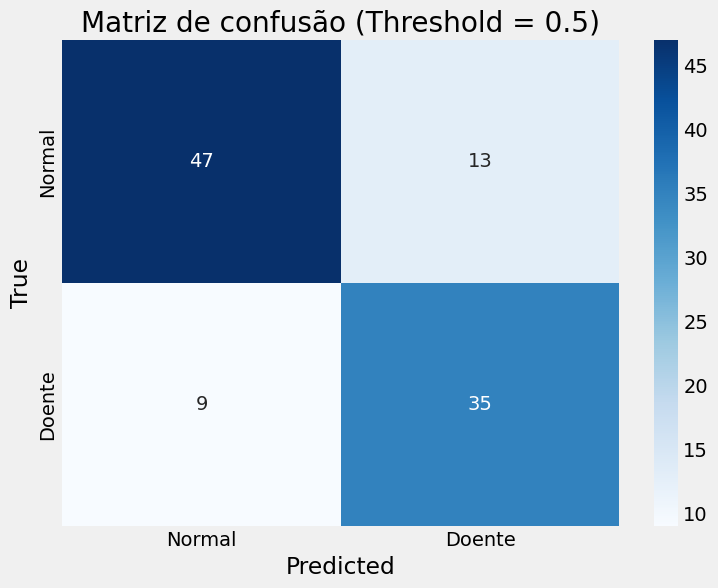

In [ ]:
# Obtendo as predições do modelo nos dados de teste
logits = arch.predict(X_test_scaled)

# Convertendo os logits para probabilidades usando a função sigmoid
y_pred_proba = sigmoid(logits).squeeze()

# Calculando a matriz de confusão com threshold padrão de 0.5
cm_thresh50 = confusion_matrix(y_test, (y_pred_proba >= 0.5))

# Plotar a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(cm_thresh50, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Doente"], yticklabels=["Normal", "Doente"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de confusão (Threshold = 0.5)")
plt.show()

In [ ]:
# Extraíndo as métricas
precision, recall = precision_recall(cm_thresh50)
print(f"Precisão: {precision:.4f} \nRecall: {recall:.4f}")

# Calcular acurácia
accuracy = accuracy_score(y_test, (y_pred_proba >= 0.5))
print(f"Acurácia: {accuracy:.4f}")

# Calcular TPR e FPR
tpr, fpr = tpr_fpr(cm_thresh50)
print(f"TPR: {tpr:.4f}\nFPR: {fpr:.4f}")

# Calcular AUC-ROC
auc_score = roc_auc_score(y_test, y_pred_proba)
print(f"AUC-ROC: {auc_score:.4f}")

Precisão: 0.7292 
Recall: 0.7955
Acurácia: 0.7885
TPR: 0.7955
FPR: 0.2167
AUC-ROC: 0.8523


Plotagem da linha de probabilidades

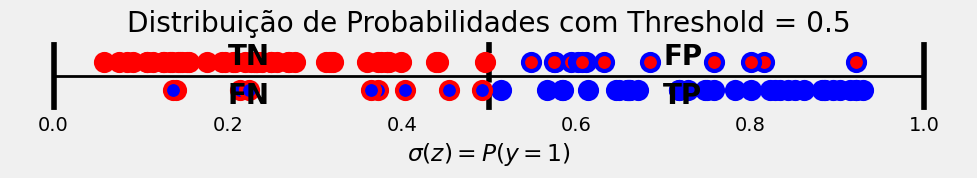

In [ ]:
# Visualizar a linha de probabilidades
fig = figure10(y_test, y_pred_proba, threshold=0.5, shift=0.04, annot=True)
plt.title('Distribuição de Probabilidades com Threshold = 0.5')
plt.show()

In [ ]:
# Calcular F1-score e especificidade
f1_score = f1_score_manual(precision, recall)
specif = specificity(cm_thresh50)

print(f"F1-Score: {f1_score:.4f}")
print(f"Especificidade: {specif:.4f}")

F1-Score: 0.7609
Especificidade: 0.7833


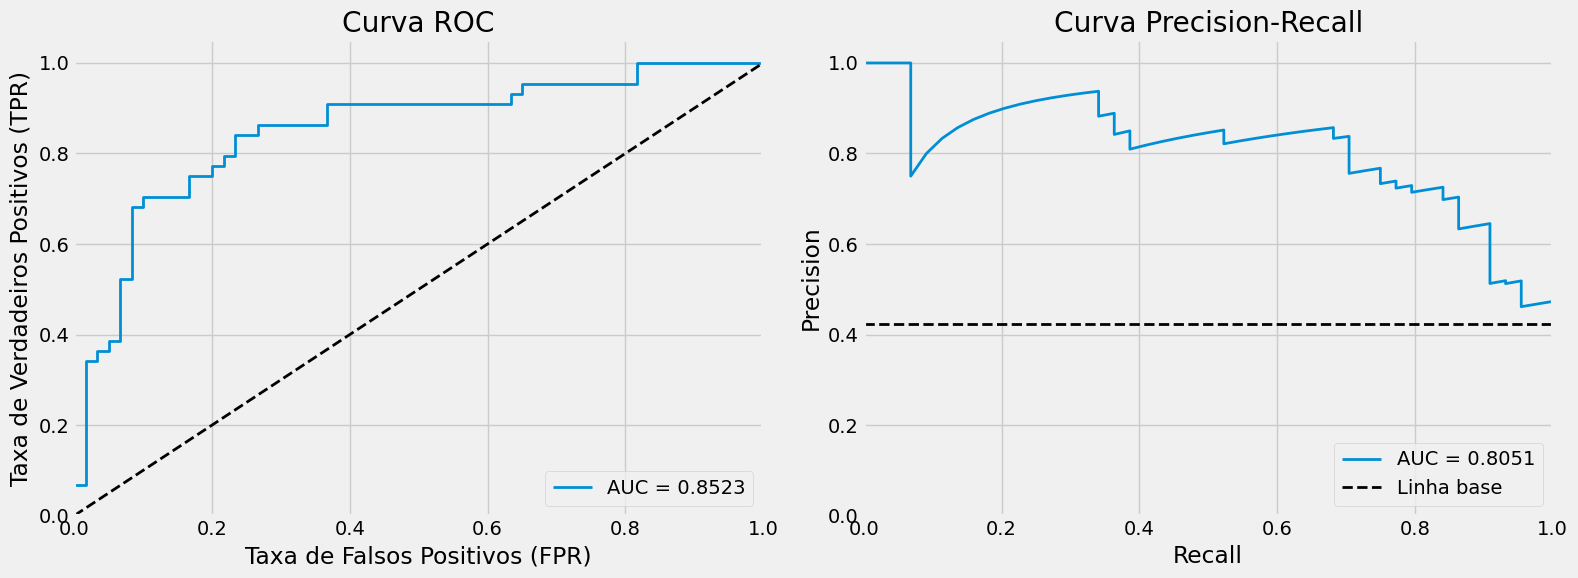

In [ ]:
# Visualizar curvas ROC e Precision-Recall
plt.figure(figsize=(16, 6))

# Curva ROC
plt.subplot(1, 2, 1)
fpr_curve, tpr_curve, thresholds_roc = roc_curve(y_test, y_pred_proba)
plt.plot(fpr_curve, tpr_curve, lw=2, label=f'AUC = {auc_score:.4f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")

# Curva Precision-Recall
plt.subplot(1, 2, 2)
precision_curve, recall_curve, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)
plt.plot(recall_curve, precision_curve, lw=2, label=f'AUC = {pr_auc:.4f}')
plt.plot([0, 1], [np.sum(y_test)/len(y_test)] * 2, 'k--', lw=2, label='Linha base')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Threshold ótimo

Caso precise da obtenção em casos de desbalanceio. Como o Dataset trabalhado foi constatado como equilibrado na etapa de EDA, a aplicação dessa correção nele irá resultar num Threshold próximo a 0,5.


In [ ]:
# Encontrar o threshold ótimo para o modelo desenvolvido
def find_optimal_threshold(y_true, y_proba, metric='f1', thresholds=None):
    if thresholds is None:
        thresholds = np.arange(0.1, 0.9, 0.02)

    best_metric = 0
    best_threshold = 0.5
    best_metrics = {}

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cm = confusion_matrix(y_true, y_pred)

        prec, rec = precision_recall(cm)
        f1 = f1_score_manual(prec, rec)
        tpr, fpr = tpr_fpr(cm)
        spec = specificity(cm)
        acc = accuracy_score(y_true, y_pred)

        # Escolher métrica para otimização
        if metric == 'f1':
            current_metric = f1
        elif metric == 'recall':
            current_metric = rec
        elif metric == 'precision':
            current_metric = prec
        else:
            # Usar uma métrica balanceada (média geométrica de TPR e TNR)
            current_metric = np.sqrt(tpr * spec)

        if current_metric > best_metric:
            best_metric = current_metric
            best_threshold = threshold
            best_metrics = {
                'threshold': threshold,
                'accuracy': acc,
                'precision': prec,
                'recall': rec,
                'specificity': spec,
                'f1_score': f1,
                'tpr': tpr,
                'fpr': fpr
            }

    return best_threshold, best_metrics

# Encontrar threshold ótimo e mostrar resultados
print("\nProcurando threshold ótimo...")
best_threshold, best_metrics = find_optimal_threshold(
    y_test, y_pred_proba, metric='f1',
    thresholds=np.arange(0.1, 0.9, 0.01)
)


In [ ]:
# Visualizar como as métricas variam com o threshold
thresholds = np.arange(0.05, 0.95, 0.05)
metrics_by_threshold = {
    'threshold': [],
    'accuracy': [],
    'precision': [],
    'recall': [],
    'specificity': [],
    'f1_score': []
}

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred)

    prec, rec = precision_recall(cm)
    f1 = f1_score_manual(prec, rec)
    spec = specificity(cm)
    acc = accuracy_score(y_test, y_pred)

    metrics_by_threshold['threshold'].append(threshold)
    metrics_by_threshold['accuracy'].append(acc)
    metrics_by_threshold['precision'].append(prec)
    metrics_by_threshold['recall'].append(rec)
    metrics_by_threshold['specificity'].append(spec)
    metrics_by_threshold['f1_score'].append(f1)

# Plotar as métricas por threshold
plt.figure(figsize=(10, 6))
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['precision'], label='Precision')
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['recall'], label='Recall')
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['f1_score'], label='F1-Score')
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['accuracy'], label='Acurácia')
plt.plot(metrics_by_threshold['threshold'], metrics_by_threshold['specificity'], label='Especificidade')
plt.axvline(x=best_threshold, color='k', linestyle='--', label=f'Threshold Ótimo ({best_threshold:.2f})')

plt.xlabel('Threshold')
plt.ylabel('Valor da Métrica')
plt.title('Métricas por Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Exportação do melhor modelo para o wandb

In [ ]:
# Login to Weights & Biases
!wandb login --relogin

In [ ]:
run = wandb.init(project="Heart_Disease",job_type="train")

In [ ]:
# training
logger.warning("Training")
arch.train(NUM_EPOCHS)

# predict
logger.warning("Infering")
predict = arch.predict(X_test_scaled)

# Evaluation Metrics
logger.warning("Evaluation metrics")
fbeta = best_metrics['f1_score']
precision = best_metrics['precision']
recall = best_metrics['recall']
acc = best_metrics['accuracy']

logger.warning("Accuracy: {}".format(acc))
logger.warning("Precision: {}".format(precision))
logger.warning("Recall: {}".format(recall))
logger.warning("F1: {}".format(fbeta))

run.summary["Acc"] = best_metrics['accuracy']
run.summary["Precision"] = best_metrics['precision']
run.summary["Recall"] = best_metrics['recall']
run.summary["F1"] = best_metrics['f1_score']


In [ ]:
run.finish()

# **Documentação dos Resultados**
Apresentar de forma clara os resultados obtidos,
incluindo as métricas calculadas, alguma discussão
sobre o que elas indicam, e possivelmente gráficos
ou tabelas que ilustram o desempenho.

In [ ]:
# Exibir os parâmetros do modelo treinado

# Mostrar a equação de regressão logística resultante
# Obter os pesos (coeficientes) e o viés (intercepto)
if hasattr(model, 'linear'):
    weights = model.linear.weight.data.cpu().numpy()[0]
    bias = model.linear.bias.data.cpu().numpy()[0]

    print("\nEquação da Regressão Logística:")
    equation = f"z = {bias:.4f}"

    for i, w in enumerate(weights):
        sign = "+" if w >= 0 else ""
        equation += f" {sign} {w:.4f}*x{i+1}"

    print(equation)
    print("\nProbabilidade de fraude = 1 / (1 + exp(-z))")

n_disease_total = df_train['target'].sum()+df_test['target'].sum()
n_samples_total = len(df_train)+len(df_test)

# Resumo dos resultados
print("\n" + "="*50)
print("RESUMO DOS RESULTADOS - PROPENSÃO A DOENÇA CARDÍACA")
print("="*50)
print("Modelo: Regressão Logística Binária")
print(f"Número de features: {input_dim}")
print(f"Total de amostras: {n_samples_total}")
print(f"Amostras de treino: {len(y_train)}, Amostras de teste: {len(y_test)}")
print(f"Proporção de propensos: {n_disease_total/n_samples_total*100:.2f}%")
print("="*50)
print(f"Métricas com threshold padrão ({0.5}):")
print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall (Sensitividade): {recall:.4f}")
print(f"Especificidade: {specif:.4f}")
print(f"F1-Score: {f1_score:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("="*50)
print(f"Métricas com threshold ótimo ({best_threshold:.2f}):")
print(f"Acurácia: {best_metrics['accuracy']:.4f}")
print(f"Precisão: {best_metrics['precision']:.4f}")
print(f"Recall (Sensitividade): {best_metrics['recall']:.4f}")
print(f"Especificidade: {best_metrics['specificity']:.4f}")
print(f"F1-Score: {best_metrics['f1_score']:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("="*50)


# Salvar o modelo e o scaler para uso futuro
torch.save(model.state_dict(), "modelo_regressao_logistica.pth")


Equação da Regressão Logística:
z = -0.3281  -0.0199*x1 + 0.1456*x2 + 0.2755*x3  -0.0379*x4 + 0.0887*x5  -0.1683*x6 + 0.2402*x7  -0.1581*x8  -0.5869*x9  -0.0492*x10  -0.0740*x11  -0.0298*x12  -0.1730*x13  -0.0745*x14  -0.7492*x15 + 0.0352*x16 + 0.0641*x17  -0.0813*x18  -0.0034*x19  -0.1246*x20

Probabilidade de fraude = 1 / (1 + exp(-z))

RESUMO DOS RESULTADOS - PROPENSÃO A DOENÇA CARDÍACA
Modelo: Regressão Logística Binária
Número de features: 20
Total de amostras: 519
Amostras de treino: 415, Amostras de teste: 104
Proporção de propensos: 42.39%
Métricas com threshold padrão (0.5):
Acurácia: 0.7885
Precisão: 0.7292
Recall (Sensitividade): 0.7955
Especificidade: 0.7833
F1-Score: 0.7609
AUC-ROC: 0.8523
Métricas com threshold ótimo (0.45):
Acurácia: 0.7981
Precisão: 0.7255
Recall (Sensitividade): 0.8409
Especificidade: 0.7667
F1-Score: 0.7789
AUC-ROC: 0.8523
